# Air Quality Measurements in New Zealand - Interpolation

* Author: Fabian Löw
* Date: June 2023

In this notebook, we will try differebt methods to interpolate gaps in the air quality data sets. The workflow consists of the following steps:

1. Import required Python packages and functions from the utils.py
2. Load the data, which corresponds to the last processing step in the notebook "01_Air_Quality_EDA" (stored as .csv)
3. Visualize the extent and distribution of missing data
4. Evaluate nearest neighbor method
5. Prepare the data to train a neural network model
6. Train and test a neural network model for estimating missing data
7. Visualize the results from the baseline model compared to the neural networks
8. Estimate missing sensor measurements across all pollutants
9. Visualize the results of filling in missing values
10. Write the resulting dataset to a new csv file

## 1. Import Python packages

Run the next cell to import the Python packages you'll be using in this lab exercise. If everything goes well you should see a message when the cell has finished running that says "All packages imported successfully!".

Note the `import utils` line. This line imports the functions that were specifically written for this lab. If you want to look at what these functions are, go to `File -> Open...` and open the `utils.py` file to have a look.

In [2]:
# Import packages
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split

import utils

# If needed, reload the utils.py (e.g. if any adjustments are made)
import importlib 
utils = importlib.reload(utils)

print('All packages imported successfully!')

All packages imported successfully!


In [3]:
# Install packages form pip, only use if requirements not already satisfied
# !pip install tensorflow

## 2. Load the data

Run the next cell to load the air quality data that was processed in the notebook "01_Air_Quality_EDA".

In [4]:
# Read in the data from the previous notebook
collapsed_df = pd.read_csv('collapsed_df.csv')
collapsed_df['DateTime'] = pd.to_datetime(collapsed_df['DateTime'])

# Define a list all of the pollutants that you will be working with
pollutants_list = ['PM2.5', 'PM10'] #,  'NO2', 'SO2', 'CO']


print(f"The dataset contains {len(collapsed_df)} entries")
print(f"The measurements are from {collapsed_df.Station.nunique()} different locations in New Zealand")

# Print out the first few lines in the dataframe
collapsed_df.head(5)

The dataset contains 105863 entries
The measurements are from 24 different locations in New Zealand


,DateTime,Station,lat,long,PM2.5,PM10
0,2005-01-01,Ashburton,-43.912238,171.755200,NaN,9.0
1,2005-01-01,Geraldine,-44.100181,171.241500,NaN,2.0
2,2005-01-01,Kaiapoi,-43.384643,172.652000,NaN,9.0
3,2005-01-01,Masterton West,-40.952307,175.646614,NaN,10.0
4,2005-01-01,Penrose,-36.904610,174.815600,NaN,12.0


## 3. Visualize the extent and distribution of missing data

### 3.1 Count null values

Run the next cell to perform the null value count you did in the last notebook as a reminder of how many missing values there are in each column of your dataset. 

In [5]:
# Print out a count of missing data for each column in the dataset
collapsed_df.isnull().sum()

DateTime        0
Station         0
lat             0
long            0
PM2.5       49896
PM10          775
dtype: int64

### 3.2. Plot measurements over time for different pollutants at different stations

Run the cell below to generate a time series plot of a selected pollutant over time as measured at a particular sensor station. Use the pulldown menus to choose different stations and pollutants, respectively. Make use of the sliders to zoom in or out on a particular range of dates. The `start_date` and `end_date` values are calculated automatically.

In [6]:
# Plot a time series for a particular date range, pollutant, and sensor station
common_start_date = min(collapsed_df.DateTime)
common_end_date = max(collapsed_df.DateTime)

start_date = common_start_date
end_date = common_end_date
utils.create_time_series_plot(collapsed_df, start_date, end_date, pollutants_list)

interactive(children=(Dropdown(description='Station', options=('Ashburton', 'Geraldine', 'Kaiapoi', 'Masterton…

### 3.3 Visualize the distribution of gaps in the data

Execute the following code cell to generate a plot depicting the count of gap size in hours (on the horizontal axis) versus the number of missing data points caused by gaps of that size (on the vertical axis). This plot will provide insight into how gaps of varying sizes in the data contribute to the issue of missing data.

5445


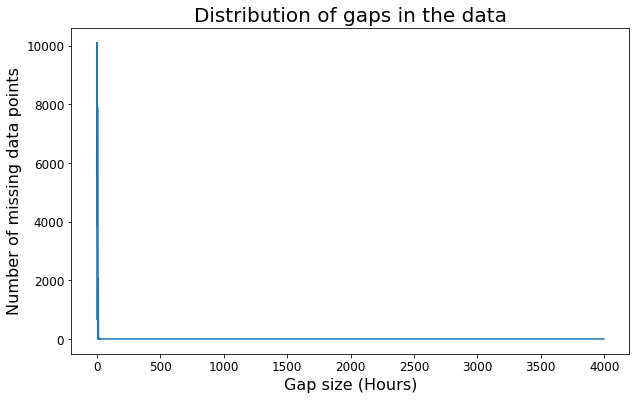

In [7]:
# Plot the distribution of gap sizes in the data
utils.plot_distribution_of_gaps(collapsed_df, target='PM2.5') # or 'PM10'

## 4. Evaluate nearest neighbor method

In the next cell, test the nearest neighbor method and calculate the Mean Absolute Error (MAE). This metric measures the average difference between the actual and predicted values. Note that the nearest neighbor method hast limitations, e.g. when there is only one measurement station in the city, it could be inaccurate to fill gaps with the "nearest" station in another city. Take into account the density of the measuremment network. Also consider more advanced techniques such as inverse distance weighting.

In [8]:
# Create a nearest neighbor model and run it on your test data
regression_scores = {}
regression_scores['baseline_model'] = utils.calculate_mae_for_nearest_station(collapsed_df, target='PM2.5')
print(regression_scores['baseline_model'])

{'MAE': 4.630670965416773}


## 5. Prepare the data to train a neural network model

Next, we will prepare the dataset to train and test a neural network model for estimating missing pullutant values (e.g. PM2.5 or PM10).

### 5.1. Remove missing values and add columns for later use with a neural network model
To accomplish this, you will begin by eliminating all rows containing missing values from the original dataset. Next, you will introduce gaps of varying sizes into the data to evaluate your model's performance. Before discarding rows with missing values, you will augment your dataset by including additional columns essential for training a neural network model. These new columns will encompass the day of the week (`day_week`). Moreover, the line of code where the variable one_hot is defined will convert the station ID into a numerical representation, indicating the specific station associated with each measurement.

In [9]:
# Define the variable you want to predict
target = 'PM2.5'

# Create new columns for day of week
raw_data_for_imputing = collapsed_df.copy()
raw_data_for_imputing['day_week'] = pd.DatetimeIndex(raw_data_for_imputing['DateTime']).weekday
# raw_data_for_imputing['hour'] = pd.DatetimeIndex(raw_data_for_imputing['DateTime']).hour

# Create a numerical representation of station ID and add as extra columns to the dataframe
one_hot = pd.get_dummies(raw_data_for_imputing.Station, prefix='Station')
raw_data_for_imputing = raw_data_for_imputing.join(one_hot)

# Make a copy of the dataframe before dropping rows with missing values
data_no_missing = raw_data_for_imputing.copy()  

# Drop all rows containing missing values
data_no_missing.dropna(inplace=True)

# Print out the number of missing values in the selected column (e.g. PM1.5 or PM10) 
# as a check (should print 0)
null_remaining = data_no_missing[target].isnull().sum()
if null_remaining == 0: 
    print('missing values removed and data prepared successfully!')

missing values removed and data prepared successfully!


In [10]:
# Visualize the firts few rows of the dataframe
data_no_missing.head()

,DateTime,Station,lat,long,PM2.5,PM10,day_week,Station_Ashburton,Station_Blenheim Bowling Club,Station_Claudelands,...,Station_St Albans,Station_St Johns,Station_Takapuna,Station_Timaru Anzac Square,Station_Waimate Kennedy,Station_Wainuiomata,Station_Waitomo District Council Yard - Queen St,Station_Wellington Central,"Station_Whangarei, Robert Street",Station_Woolston
5445,2006-08-10,Penrose,-36.90461,174.8156,10.0,18.0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5459,2006-08-11,Penrose,-36.90461,174.8156,9.0,18.0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5473,2006-08-12,Penrose,-36.90461,174.8156,5.0,13.0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5487,2006-08-13,Penrose,-36.90461,174.8156,5.0,14.0,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5501,2006-08-14,Penrose,-36.90461,174.8156,8.0,19.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 5.2 Split data into training and testing sets

To ensure a fair comparison between your baseline model and the neural network model, it is crucial to conduct the test on the same subset of the data. In this step, you will split the data and create a separate testing dataset. This testing dataset will be used to evaluate both your baseline model and the neural network model. Execute the next cell to split out 20% of the data for testing purposes.

In [11]:
train_data, test_data = train_test_split(data_no_missing, test_size=0.20, random_state=57)

print(f'Train dataset size: {train_data.shape}')
print(f'Test dataset size: {test_data.shape}')

Train dataset size: (44153, 31)
Test dataset size: (11039, 31)




    
</details>



## 6. Train and test a neural network model for estimating missing data

Execute the following code cell to train and test a neural network model for estimating missing PM2.5 values. In this scenario, the neural network needs to learn the relationship between PM2.5 values and other pollutant values, as well as factors such as time of day, day of the week, and station location. It's important to note that the actual neural network used in training is larger than the one depicted in the image, consisting of two hidden layers with 64 and 32 units, respectively.

In [12]:
# Define the features you will base your predictions on 
pollutants_except_target = [i for i in pollutants_list if i != target]
feature_names = ['day_week'] + list(one_hot.columns) + pollutants_except_target

# Define the neural network model architecture
model_dense = utils.build_keras_model(input_size=len(feature_names))
model_lstm = utils.build_lstm_model(input_size=len(feature_names))

# Train and test the models (simple dense and LSTM)
model_dense, scaler, mae_dense = utils.train_and_test_model(feature_names, target, train_data, test_data, model_dense)
model_lstm, scaler, mae_lstm = utils.train_and_test_model(feature_names, target, train_data, test_data, model_lstm)

2023-07-05 23:35:04.482011: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
690/690 [==============================] - 1s 1ms/step - loss: 11.9925 - mae: 2.2725
Epoch 2/100
690/690 [==============================] - 1s 1ms/step - loss: 10.2169 - mae: 2.1212
Epoch 3/100
690/690 [==============================] - 1s 1ms/step - loss: 9.9164 - mae: 2.0908
Epoch 4/100
690/690 [==============================] - 1s 978us/step - loss: 9.8296 - mae: 2.0794
Epoch 5/100
690/690 [==============================] - 1s 1ms/step - loss: 9.7460 - mae: 2.0719
Epoch 6/100
690/690 [==============================] - 1s 1ms/step - loss: 9.5941 - mae: 2.0664
Epoch 7/100
690/690 [==============================] - 1s 1ms/step - loss: 9.5339 - mae: 2.0592
Epoch 8/100
690/690 [==============================] - 1s 1ms/step - loss: 9.4909 - mae: 2.0552
Epoch 9/100
690/690 [==============================] - 1s 1ms/step - loss: 9.4279 - mae: 2.0531
Epoch 10/100
690/690 [==============================] - 1s 1ms/step - loss: 9.3370 - mae: 2.0430
Epoch 11/100
690/690 [=============

690/690 [==============================] - 1s 1ms/step - loss: 8.9605 - mae: 2.0128
Epoch 85/100
690/690 [==============================] - 1s 1ms/step - loss: 9.0045 - mae: 2.0200
Epoch 86/100
690/690 [==============================] - 1s 1ms/step - loss: 8.9487 - mae: 2.0143
Epoch 87/100
690/690 [==============================] - 1s 1ms/step - loss: 8.9269 - mae: 2.0120
Epoch 88/100
690/690 [==============================] - 1s 1ms/step - loss: 8.9775 - mae: 2.0177
Epoch 89/100
690/690 [==============================] - 1s 1ms/step - loss: 9.0049 - mae: 2.0185
Epoch 90/100
690/690 [==============================] - 1s 1ms/step - loss: 8.9827 - mae: 2.0164
Epoch 91/100
690/690 [==============================] - 1s 1ms/step - loss: 8.9622 - mae: 2.0153
Epoch 92/100
690/690 [==============================] - 1s 1ms/step - loss: 8.9026 - mae: 2.0124
Epoch 93/100
690/690 [==============================] - 1s 1ms/step - loss: 8.9409 - mae: 2.0151
Epoch 94/100
690/690 [=====================

690/690 [==============================] - 1s 2ms/step - loss: 8.8305 - mae: 2.0034
Epoch 69/100
690/690 [==============================] - 1s 2ms/step - loss: 8.8573 - mae: 2.0022
Epoch 70/100
690/690 [==============================] - 1s 2ms/step - loss: 8.8714 - mae: 2.0031
Epoch 71/100
690/690 [==============================] - 1s 2ms/step - loss: 8.8490 - mae: 2.0028
Epoch 72/100
690/690 [==============================] - 1s 2ms/step - loss: 8.8533 - mae: 1.9998
Epoch 73/100
690/690 [==============================] - 1s 2ms/step - loss: 8.9054 - mae: 2.0028
Epoch 74/100
690/690 [==============================] - 1s 2ms/step - loss: 8.8678 - mae: 2.0019
Epoch 75/100
690/690 [==============================] - 1s 2ms/step - loss: 8.8592 - mae: 2.0017
Epoch 76/100
690/690 [==============================] - 1s 2ms/step - loss: 8.8601 - mae: 1.9996
Epoch 77/100
690/690 [==============================] - 1s 2ms/step - loss: 8.8405 - mae: 2.0010
Epoch 78/100
690/690 [=====================

Compare the **MAE** obtained using the 2 methods (nearest neighbor and two neural network architectures). This value has been obtained using the same test set so its comparable.

In [13]:
# Print out the MAE result of the methods tested
regression_scores['neural_network_model_dense'] = mae_dense
regression_scores['neural_network_model_lstm'] = mae_lstm

for model_name, model_score in regression_scores.items():
    score_value = model_score['MAE']
    print(model_name, ' : {:.3f}'.format(float(score_value)))

baseline_model  : 4.631
neural_network_model_dense  : 2.014
neural_network_model_lstm  : 2.035


## 7. Visualize the results from the baseline model compared to the neural networks

Run the next cell to visualize the results of the baseline model and the neural network model. Use the pulldown menus to choose between different station locations and different "window" or gap sizes in hours. Use the slider to choose the start index of the window you want to investigate. You can also change the `start_date` and `end_date` values to other dates in 2021.  

In [14]:
# Define start and end prrtiod for the plot
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 6, 6)

# Create a line plot showing results from  baseline model vs. neural networks
utils.create_plot_with_preditions(data_no_missing, 
                                  model_dense, 
                                  scaler, 
                                  feature_names, 
                                  target,
                                  start_date,
                                  end_date)

interactive(children=(Dropdown(description='Station', options=('Penrose', 'Takapuna', 'Patumahoe', 'St Albans'…

## 8. Estimate missing sensor measurements across all pollutants

With the first line of code below you will estimate missing values for all non-PM2.5 pollutants using the nearest neighbors method. With the second line, you'll use your neural network next to esimate missing values for PM2.5. The last line simply prints out the number of missing values in each column again, which should be zero if everything went well. 

In [15]:
# Estimate non-PM2.5 missing values with the nearest neighbor method
imputed_with_baseline_model = utils.impute_nontarget_missing_values_interpolate(raw_data_for_imputing, 
                                                                                feature_names,
                                                                                pollutants_list,
                                                                                target)

# Estimate missing PM2.5 values 
data_with_imputed = utils.impute_target_missing_values_neural_network(raw_data_for_imputing, 
                                                                      model_dense, 
                                                                      scaler, 
                                                                      imputed_with_baseline_model,
                                                                      pollutants_list,
                                                                      target)

# Print out a count of missing data for each column in the dataset with imputed values, should be zero ...
data_with_imputed[pollutants_list].isnull().sum()

PM2.5    0
PM10     0
dtype: int64

In [16]:
# Print out a sample of the dataframe
data_with_imputed.sample(5)

,DateTime,Station,lat,long,PM2.5,PM10,PM2.5_imputed_flag,PM10_imputed_flag
5122,2006-07-18,Ashburton,-43.912238,171.755200,69.587654,88.0,neural network,None
19728,2009-05-09,Timaru Anzac Square,-44.404483,171.249700,8.620999,17.0,neural network,None
88763,2019-01-03,Kaiapoi,-43.384643,172.652000,6.000000,16.0,None,None
43417,2013-03-13,Masterton West,-40.952307,175.646614,5.000000,8.0,None,None
60965,2015-08-30,Wainuiomata,-41.267711,174.953751,5.000000,8.0,None,None


The flag columns exhibit distinct values: `None` indicates the presence of original data, `'neural network'` signifies imputed values using the neural network, and `'interpolated'` represents values obtained through interpolation.

## 9. Visualize the results of filling in missing values

You can use the flag columns you recorded above to distinguish between original and estimated data, and you can visualize this by running the cell below.

In [17]:
# Define a start and end date and visualize missing values that have been imputed
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 4, 30)
utils.create_time_series_plot(data_with_imputed, start_date, end_date, pollutants_list)

interactive(children=(Dropdown(description='Station', options=('Ashburton', 'Geraldine', 'Kaiapoi', 'Masterton…

## 10. Write the resulting dataset to a new csv file

In [116]:
# Write imputed data as new csv file
data_with_imputed.to_csv('full_data_with_imputed_values.csv')

*[End of notebook]*